We load the packages.

In [203]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri

Then, one defines the domain here. I think the easiest way to do this is to hardcode the domain once, then refine it.

1. square
2. triangle
3. L-shaped

I used a domain of size 1 in x, that I can easily scale be dividing by the number of elements in x (L) of size h such that L\*h=1 always. However there are (L+1)^2 nodes here for a square. There are therefore L\*H elements in this construction.

Then, the array coordinates is of shape ((L+1)\*(H+1), 2), where each row is (x-position, y-position). I try to go anticlockwise for everynodes.

If L=H=2, we have the first case, while if L=H=4, we have the second case.

In [204]:
#number of elements in x and y
L1=2
L2=4
H1=2
H2=4
coordinates1=np.zeros(((L1+1)*(H1+1),2))
coordinates2=np.zeros(((L2+1)*(H2+1),2))
i=0
while True:
    coordinates1[i,0]=(i%(L1+1))/L1
    coordinates1[i,1]=i//(L1+1)/L1
    i+=1
    if i==(L1+1)*(H1+1):
        break
i=0
while True:
    coordinates2[i,0]=(i%(L2+1))/L2
    coordinates2[i,1]=i//(L2+1)/L2
    i+=1
    if i==(L2+1)*(H2+1):
        break

Now, it is time for the elements. So every element is defined counterclockwise. The array elements3 is of shape (2\*L\*H,3), where each row is like this (node1, node2, node3).

In [205]:
"The first line is the first case, the second line is the second case"
elements31=np.array([[0,1,3],[1,4,3],[1,2,4],[2,5,4],[3,4,6],[4,7,6],[4,5,7],[5,8,7]])
elements32=np.array([[0,1,5],[1,6,5],[1,2,6],[2,7,6],[2,3,7],[3,8,7],[3,4,8],[4,9,8],\
                    [5,6,10],[6,11,10],[6,7,11],[7,12,11],[7,8,12],[8,13,12],[8,9,13],[9,14,13],\
                    [10,11,15],[11,16,15],[11,12,16],[12,17,16],[12,13,17],[13,18,17],[13,14,18],[14,19,18],\
                    [15,16,20],[16,21,20],[16,17,21],[17,22,21],[17,18,22],[18,23,22],[18,19,23],[19,24,23]])

Suppose now that the given square is such that on the sides it is the Neumann BC and on the top and bottom the Dirichlet BC. Both are size (2\*H,2) and (2\*L,2) respectively.

In [206]:
"these are triangle 0, 3, 4, 7 resp." 
neumannBC1=np.array([[0,3],[2,5],[3,6],[5,8]])
neumannBC2=np.array([[0,5],[5,10],[10,15],[15,20],[4,9],[9,14],[14,19],[19,24]])
"these are triangle 0, 2, 5, 7 resp."
dirichletBC1=np.array([[0,1],[1,2],[6,7],[7,8]])
dirichletBC2=np.array([[0,1],[1,2],[2,3],[3,4],[20,21],[21,22],[22,23],[23,24]])

The next function is there in order to compute all the different part of the stiffness matrix (it is the M matrix in the manual).

We also define the force function f. This is whatever we want it to be.

And also the stress function g. This is for Neumann BC.

And also the Dirichlet BC.

And also the show function.

In [207]:
def stima3(vertices):
    "function that takes in argument the vertices of a triangle and gives the corresponding stiffness\
    matrix part"
    d=np.size(vertices,1)
    G=np.linalg.lstsq(np.concatenate((np.ones((1,d+1)),vertices.T),axis=0),\
                      np.concatenate((np.zeros((1,d)),np.eye(d))))
    G=np.around(G[0])
    M=np.linalg.det(np.concatenate((np.ones((1,d+1)),vertices.T),axis=0))\
    *(G@G.T)*np.prod(np.arange(1,d))
    return M

def f(x):
    "Insert here the proper function that one wants. Here it is asssumed we are using triangles."
    return np.ones((3,1))

def g(x):
    "Insert here the proper function that one wants"
    return np.zeros((np.size(x,axis=0),1))

def u_d(x):
    "Insert here the proper function that one wants. Here we assume u_d=0 at the boundaries."
    return np.zeros((np.size(x,axis=0),2,1))

def show(coordinates,u):
    fig=plt.figure()
    ax=fig.gca(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u.reshape(u.size))
    return plt.show()


Now we define the free nodes which will reprensent the nodes not being forced to be something by Dirichlet. Also we define the stiffness matrix A and the output vector b.

Then we can assemble our stiffness mastrix by a simple for loop.

In [209]:
FreeNodes1=np.setdiff1d(np.arange(0,np.size(coordinates1,0)),np.unique(dirichletBC1,axis=0))
A1=np.zeros((np.size(coordinates1,0),np.size(coordinates1,0)))
b1=np.zeros((np.size(coordinates1,0),1))
u1=np.zeros((np.size(coordinates1,0),1))
for j in np.arange(0,np.size(elements31,0)):
    #assembly of stiffness matrix
    A1[np.ix_(elements31[j],elements31[j])]+=stima3(coordinates1[elements31[j]])
    #volume force
    b1[elements31[j]]+=np.linalg.det(np.concatenate((np.ones((1,3)),coordinates1[elements31[j]].T),axis=0))\
    *f(np.sum(coordinates1[elements31[j]],axis=0)/3)/6
    
FreeNodes2=np.setdiff1d(np.arange(0,np.size(coordinates2,0)),np.unique(dirichletBC2,axis=0))
A2=np.zeros((np.size(coordinates2,0),np.size(coordinates2,0)))
b2=np.zeros((np.size(coordinates2,0),1))
u2=np.zeros((np.size(coordinates2,0),1))
for j in np.arange(0,np.size(elements32,0)):
    #assembly of stiffness matrix
    A2[np.ix_(elements32[j],elements32[j])]+=stima3(coordinates2[elements32[j]])
    #volume force
    b2[elements32[j]]+=np.linalg.det(np.concatenate((np.ones((1,3)),coordinates2[elements32[j]].T),axis=0))\
    *f(np.sum(coordinates2[elements32[j]],axis=0)/3)/6

/Users/antoinesavard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


Then we have to deal with the boundary conditions. First Neumann, than Dirichlet:

In [210]:
#Neumann
for j in np.arange(0,np.size(neumannBC1,0)):
    b1[neumannBC1[j]]+=np.sqrt((coordinates1[neumannBC1[j,0]]-coordinates1[neumannBC1[j,1]])@\
                                    (coordinates1[neumannBC1[j,0]]-coordinates1[neumannBC1[j,1]]))\
    *g(np.sum(coordinates1[neumannBC1[j]],axis=0)/2)/2

#Dirichlet
'The error here is somehow in the evalution of u'
u1[np.unique(dirichletBC1,axis=0)]=u_d(coordinates1[np.unique(dirichletBC1,axis=0)])
b1-=A1@u1

#Neumann
for j in np.arange(0,np.size(neumannBC2,0)):
    b2[neumannBC2[j]]+=np.sqrt((coordinates2[neumannBC2[j,0]]-coordinates2[neumannBC2[j,1]])@\
                                    (coordinates2[neumannBC2[j,0]]-coordinates2[neumannBC2[j,1]]))\
    *g(np.sum(coordinates2[neumannBC2[j]],axis=0)/2)/2

#Dirichlet
'The error here is somehow in the evalution of u'
u2[np.unique(dirichletBC2,axis=0)]=u_d(coordinates2[np.unique(dirichletBC2,axis=0)])
b2-=A2@u2

Then, all is left is to compute the solution:

/Users/antoinesavard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


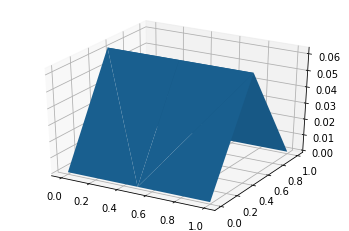

/Users/antoinesavard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


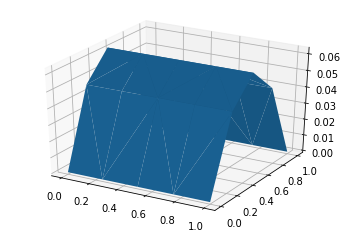

In [211]:
u1[FreeNodes1]=np.linalg.lstsq(A1[np.ix_(FreeNodes1,FreeNodes1)],b1[FreeNodes1])[0]
show(coordinates1,u1)

u2[FreeNodes2]=np.linalg.lstsq(A2[np.ix_(FreeNodes2,FreeNodes2)],b2[FreeNodes2])[0]
show(coordinates2,u2)

As we can see, as we get a smaller grid, the solution is more precise. However, I was not able to find the error of this method, since I cannot seem to find the true value.